In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

Available workers: 16


In [3]:
train_or_load_pretrained = "train" # Set this to "train" if you want to train a new network
pretrained_modelname = "model_psd_best"
num_epochs = 30
batch_size = 32
batch_size_val = 32
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'psdl2'
modeltype = 'psdl2'
normalize = ""#"sample"

train_df = pd.read_parquet('../data_created/suzmel_traindf_plus_extra_plus_nudf_plus_rpidf.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(lowcut=140, highcut=1500), RandomRoll(p=1.) ,RandomFlip(), RandomNoise(p=7.), TransformWingbeat(setting='psdl2')] # ,RandomFlip(), RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass(lowcut=140, highcut=1500), TransformWingbeat(setting='psdl2')]
BASE_DATACREATEDDIR

Path('/home/kalfasyan/projects/wbai/data_created')

In [4]:
X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

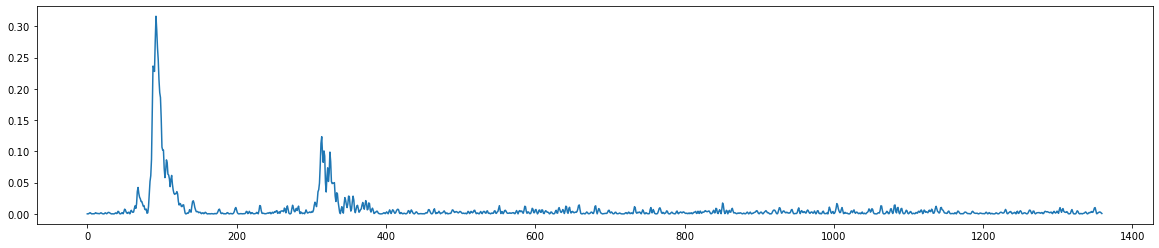

In [5]:
plt.figure(figsize=(20,4))
plt.plot(train_dataset[1][0].T);

In [6]:
outs = 2
if modeltype == 'psdl2':
    model = DrosophilaNetRAW(outputs=outs, dropout_p=.2)
else:
    raise ValueError()

class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(label_smoothing=0.25)#weight=torch.Tensor(weight).cuda())
elif outs == 2:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.25)#weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [7]:
if train_or_load_pretrained == 'train':
    # Choosing whether to train on a gpu
    train_on_gpu = torch.cuda.is_available()
    print(f'Train on gpu: {train_on_gpu}')# Number of gpus
    model = model.to('cuda', dtype=torch.float)

    results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
    best_valacc = 0
    # Model training
    for epoch in range(num_epochs):
        # Going through the training set
        correct_train = 0
        model.train()
        for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):        
            y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
            for param in model.parameters():
                param.grad = None
            pred = model(x_batch)
            if outs == 1:
                y_batch = y_batch.type(torch.FloatTensor).cuda()
                correct_train += ((pred>0.5).int().squeeze() == y_batch.squeeze()).float().sum().item()
                loss = criterion(pred, y_batch.unsqueeze(1))
            elif outs == 2:
                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
                loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
        train_accuracy = correct_train / len(train_dataset) * 100.

        # Going through the validation set
        correct_valid = 0
        model.eval()
        for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
            pred = model(x_batch)
            if outs == 1:
                y_batch = y_batch.type(torch.FloatTensor).cuda()
                correct_valid += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
                val_loss = criterion(pred, y_batch.unsqueeze(1))
            elif outs == 2:
                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
                val_loss = criterion(pred, y_batch)
        valid_accuracy = correct_valid / len(valid_dataset) * 100.

        scheduler.step()
    #     early_stopping(val_loss, model)
    #     if early_stopping.early_stop:
    #         print("Early stopping")
    #         break

            # Printing results
        print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")

        is_best = valid_accuracy > best_valacc
        if is_best:
            print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
        best_valacc = max(valid_accuracy, best_valacc)
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_valacc': best_valacc,
            'loss': results['loss'].append(loss.detach().cpu()),
            'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
            'train_accuracy': results['train_accuracy'].append(train_accuracy),
            'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
            'optimizer' : optimizer.state_dict(),
        }, is_best, "model_psd")
elif train_or_load_pretrained == 'load':
    model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/{pretrained_modelname}.pth.tar', model, optimizer)
    model = model.to('cuda', dtype=torch.float)
else:
    print("Set train_or_load_pretrained to either \'train\' or \'load\'")

Train on gpu: True


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 82.03it/s]


Epoch 0: train_acc: 81.3% loss: 0.5373920,  val_loss: 0.4520186 val_acc: 84.4%
Validation accuracy improved from 0.00 to 84.35. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 83.35it/s]


Epoch 1: train_acc: 84.0% loss: 0.6683083,  val_loss: 0.4302290 val_acc: 85.6%
Validation accuracy improved from 84.35 to 85.62. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 82.55it/s]


Epoch 2: train_acc: 84.6% loss: 0.5219628,  val_loss: 0.4034894 val_acc: 86.1%
Validation accuracy improved from 85.62 to 86.09. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 85.49it/s]


Epoch 3: train_acc: 84.9% loss: 0.4168932,  val_loss: 0.4985203 val_acc: 85.8%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 89.43it/s]


Epoch 4: train_acc: 85.2% loss: 0.4267357,  val_loss: 0.5445620 val_acc: 86.8%
Validation accuracy improved from 86.09 to 86.76. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 88.38it/s]


Epoch 5: train_acc: 85.4% loss: 0.4981089,  val_loss: 0.4269337 val_acc: 87.0%
Validation accuracy improved from 86.76 to 87.04. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 87.78it/s]


Epoch 6: train_acc: 85.7% loss: 0.5806398,  val_loss: 0.4567415 val_acc: 87.3%
Validation accuracy improved from 87.04 to 87.25. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 90.82it/s]


Epoch 7: train_acc: 85.9% loss: 0.6071208,  val_loss: 0.4955225 val_acc: 86.8%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 84.66it/s]


Epoch 8: train_acc: 86.1% loss: 0.4814458,  val_loss: 0.4968636 val_acc: 87.6%
Validation accuracy improved from 87.25 to 87.55. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 90.65it/s]


Epoch 9: train_acc: 86.1% loss: 0.4253743,  val_loss: 0.5334175 val_acc: 86.7%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 90.15it/s] 


Epoch 10: train_acc: 86.3% loss: 0.5483035,  val_loss: 0.4754870 val_acc: 87.0%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 92.24it/s] 


Epoch 11: train_acc: 86.5% loss: 0.5251237,  val_loss: 0.4990281 val_acc: 87.6%
Validation accuracy improved from 87.55 to 87.59. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 93.05it/s] 


Epoch 12: train_acc: 86.4% loss: 0.6178861,  val_loss: 0.4572248 val_acc: 87.3%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 88.01it/s] 


Epoch 13: train_acc: 86.3% loss: 0.5683717,  val_loss: 0.4425102 val_acc: 87.9%
Validation accuracy improved from 87.59 to 87.87. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 92.35it/s] 


Epoch 14: train_acc: 86.3% loss: 0.4580708,  val_loss: 0.4225769 val_acc: 87.4%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 88.62it/s] 


Epoch 15: train_acc: 86.5% loss: 0.5338246,  val_loss: 0.4694869 val_acc: 87.5%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 91.57it/s] 


Epoch 16: train_acc: 86.6% loss: 0.5167972,  val_loss: 0.6336347 val_acc: 87.5%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 89.72it/s] 


Epoch 17: train_acc: 86.7% loss: 0.5326773,  val_loss: 0.4027348 val_acc: 87.7%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 85.41it/s]


Epoch 18: train_acc: 86.6% loss: 0.5886424,  val_loss: 0.6565819 val_acc: 87.5%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 91.06it/s] 


Epoch 19: train_acc: 86.6% loss: 0.4875864,  val_loss: 0.6366011 val_acc: 88.1%
Validation accuracy improved from 87.87 to 88.11. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 89.31it/s]


Epoch 20: train_acc: 86.8% loss: 0.5009924,  val_loss: 0.5583014 val_acc: 87.6%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 88.84it/s]


Epoch 21: train_acc: 86.8% loss: 0.5586569,  val_loss: 0.4247712 val_acc: 88.2%
Validation accuracy improved from 88.11 to 88.21. Saving model..


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 92.50it/s] 


Epoch 22: train_acc: 86.9% loss: 0.4882039,  val_loss: 0.4625909 val_acc: 87.7%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 90.24it/s] 


Epoch 23: train_acc: 86.9% loss: 0.4526732,  val_loss: 0.5131221 val_acc: 87.9%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 90.69it/s] 


Epoch 24: train_acc: 86.9% loss: 0.5951358,  val_loss: 0.4230471 val_acc: 88.0%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 92.74it/s] 


Epoch 25: train_acc: 87.1% loss: 0.4433641,  val_loss: 0.4945925 val_acc: 87.3%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 89.22it/s]


Epoch 26: train_acc: 87.3% loss: 0.4556091,  val_loss: 0.4331632 val_acc: 87.9%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 92.43it/s] 


Epoch 27: train_acc: 87.0% loss: 0.5083074,  val_loss: 0.5549697 val_acc: 87.7%


Validating..	: 100%|██████████| 280/280 [00:02<00:00, 93.70it/s] 


Epoch 28: train_acc: 87.2% loss: 0.4175626,  val_loss: 0.5561985 val_acc: 87.9%


Validating..	: 100%|██████████| 280/280 [00:03<00:00, 89.53it/s] 


Epoch 29: train_acc: 87.1% loss: 0.4545754,  val_loss: 0.4865070 val_acc: 87.6%


# MORE LAYERS?

## Testing on test set

In [8]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_psd_best.pth.tar', model, optimizer)
_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 929/929 [00:10<00:00, 92.83it/s] 

Accuracy: 81.17
Balanced accuracy: 80.47
Confusion matrix: 
[[0.66164403 0.33835597]
 [0.05223306 0.94776694]]


## Testing on extra mebios data

In [9]:
extra_df = pd.read_csv('../data_created/suzmel_extra.csv')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
_ = test_model(model,extra_dataloader, extra_dataset)

Testing..	: 100%|██████████| 797/797 [00:08<00:00, 94.01it/s] 

Accuracy: 93.04
Balanced accuracy: 86.53
Confusion matrix: 
[[0.79230211 0.20769789]
 [0.06174068 0.93825932]]


### Confusion matrix

100%|██████████| 929/929 [00:09<00:00, 98.15it/s] 


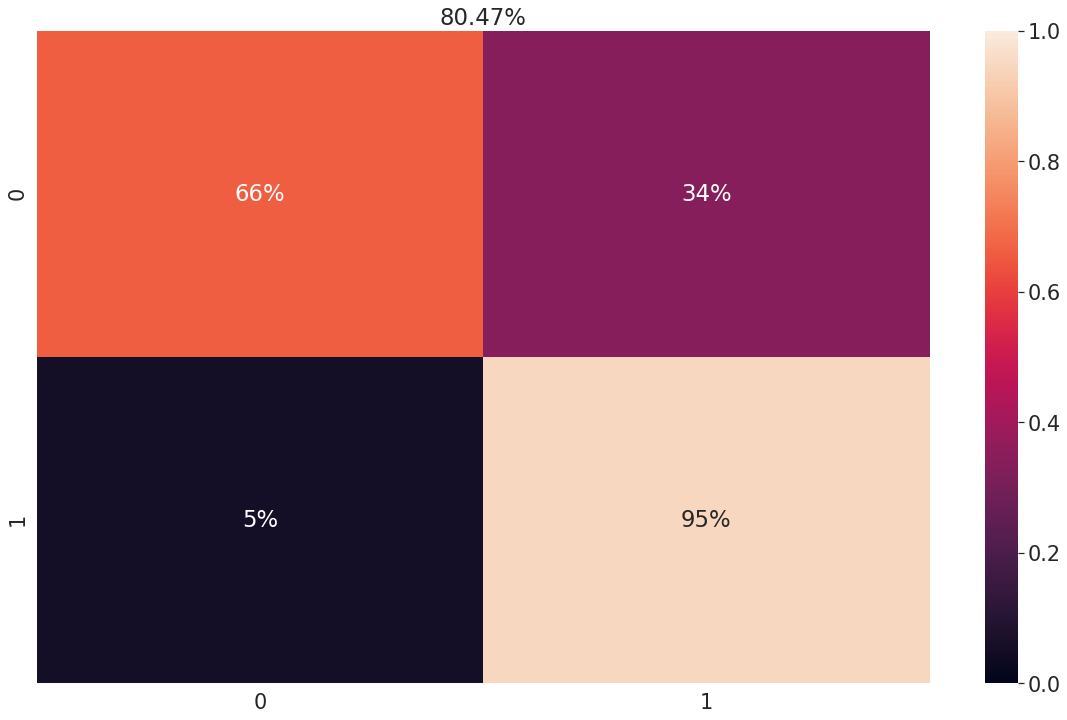

In [10]:
from utils import get_all_preds
df_out = get_all_preds(model, test_dataloader, dataframe=True, final_nodes=2)
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");
#plt.savefig("/home/kalfasyan/Dropbox/kuleuven/paper2_figures/confmatmain.eps", format='eps', bbox_inches='tight');